### TimeseriesExplainer for time series anomaly detection

The class `TimeseriesExplainer` is designed for time series data, acting as a factory of the supported tabular explainers such as SHAP and MACE. `TimeseriesExplainer` provides a unified easy-to-use interface for all the supported explainers. In practice, we recommend applying `TimeseriesExplainer` to generate explanations instead of using a specific explainer in the package `omnixai.explainers.timeseries`.

In [1]:
import sys
import os

module_path = os.path.abspath('E:/Codes/OmniXAI/omnixai/')
if module_path not in sys.path:
    sys.path.append(module_path)

# For Jupyter notebooks or interactive environments where __file__ is not defined
try:
    # Try to use __file__ if available
    directory = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # If __file__ is not defined (e.g., in Jupyter), use the current working directory
    directory = os.path.abspath('')
    
sys.path.append(os.path.dirname(directory))

In [2]:
# This default renderer is used for sphinx docs only. Please delete this cell in IPython.
import plotly.io as pio
pio.renderers.default = "png"

In [3]:
import os
import numpy as np
import pandas as pd
from omnixai.data.timeseries import Timeseries
from omnixai.explainers.timeseries import TimeseriesExplainer

The time series data used here is a sythentic univariate time series dataset. We recommend using `Timeseries` to represent a time series dataset. `Timeseries` contains one univariate/multivariate time series, which can be constructed from a pandas dataframe (the index in the dataframe represents the timestamps and the columns are the variables).

In [4]:
# Load the time series dataset
df = pd.read_csv(os.path.join("./data", "timeseries.csv"))
df["timestamp"] = pd.to_datetime(df["timestamp"], unit='s')
df = df.rename(columns={"horizontal": "values"})
df = df.set_index("timestamp")
df = df.drop(columns=["anomaly"])
print(df)

                       values
timestamp                    
1970-01-01 00:00:00  1.928031
1970-01-01 00:05:00 -1.156620
1970-01-01 00:10:00 -0.390650
1970-01-01 00:15:00  0.400804
1970-01-01 00:20:00 -0.874490
...                       ...
1970-02-04 16:55:00  0.362724
1970-02-04 17:00:00  2.657373
1970-02-04 17:05:00  1.472341
1970-02-04 17:10:00  1.033154
1970-02-04 17:15:00  2.950466

[10000 rows x 1 columns]


In [5]:
# Split the dataset into training and test splits
train_df = df.iloc[:9150]
test_df = df.iloc[9150:9300]
# A simple threshold for detecting anomaly data points
threshold = np.percentile(train_df["values"].values, 90)

The outputs of the detector are anomaly scores instead of anomaly labels (0 or 1). A test instance is more anomalous if it has a higher anomaly score. 

In [6]:
# A simple detector for determining whether a window of time series is anomalous
def detector(ts: Timeseries):
    anomaly_scores = np.sum((ts.values > threshold).astype(int))
    return anomaly_scores / ts.shape[0]

To initialize `TimeseriesExplainer`, we need to set the following parameters:

  - `explainers`: The names of the explainers to apply, e.g., ["shap", "mace"].
  - `data`: The data used to initialize explainers. ``data`` is the training dataset for training the machine learning model.
  - `model`: The ML model to explain, e.g., a black-box anomaly detector.
  - `preprocess`: The preprocessing function converting the raw data (a `Timeseries` instance) into the inputs of `model`.
  - `postprocess` (optional): The postprocessing function transforming the outputs of ``model`` to a user-specific form, e.g., the anomaly labels.
  - `mode`: The task type, e.g., "anomaly_detection" or "forecasting".
  - `params`: Additional parameters for each explainer, e.g., MACE requires a threshold to determine anomaly labels.

In [7]:
# Initialize a TimeseriesExplainer
explainers = TimeseriesExplainer(
    explainers=["shap", "mace"],
    mode="anomaly_detection",
    data=Timeseries.from_pd(train_df),
    model=detector,
    preprocess=None,
    postprocess=None,
    params={"mace": {"threshold": 0.001}}
)
# Generate explanations
test_instances = Timeseries.from_pd(test_df)
local_explanations = explainers.explain(
    test_instances,
    params={"shap": {"nsamples": 1000}}
)

  0%|          | 0/1 [00:00<?, ?it/s]

 |███████████████████████████████████████-| 99.5% 

`ipython_plot` plots the generated explanations in IPython. Parameter `index` indicates which instance to plot, e.g., `index = 0` means plotting the first instance in `test_instances`.

SHAP results:


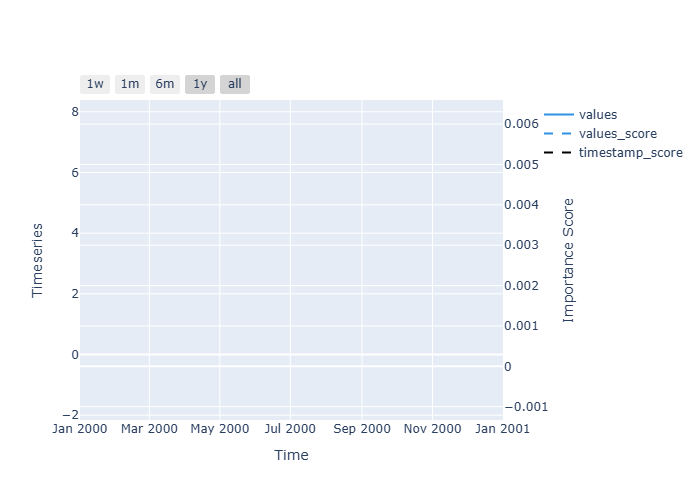

MACE results:


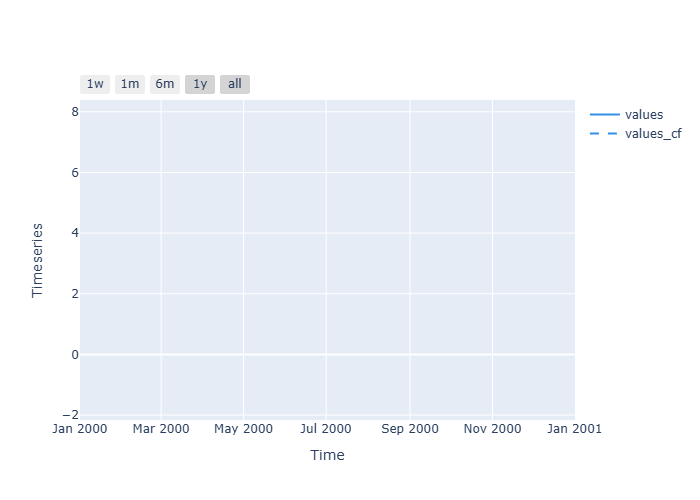

In [8]:
index=0
print("SHAP results:")
local_explanations["shap"].ipython_plot(index)
print("MACE results:")
local_explanations["mace"].ipython_plot(index)

The dash lines show the importance scores and the counterfactual example, respectively. SHAP shows the most important timestamps make this test instance detected as an anomaly. MACE provides a counterfactual example showing that it will not be detected as an anomaly if the metric values from 20:00 to 00:00 are around 2.0.

Given the generated explanations, we can launch a dashboard (a Dash app) for visualization by setting the test instance and the generated local explanations.

In [8]:
from omnixai.visualization.dashboard import Dashboard
dashboard = Dashboard(instances=test_instances, local_explanations=local_explanations)
dashboard.show()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "omnixai.visualization.dashboard" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
